#### Import the Necessary Python Packages

In [3]:
%matplotlib inline
import numpy as np
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

#### Define the GibbsProbit function. This function implements the paper :
Bayesian Analysis of Binary and Polychotomous Response Data, James H. Albert and Siddhartha Chib, Journal of the American Statistical Association, Vol. 88, No. 422 (Jun., 1993), pp. 669-679

In [13]:
def GibbsProbit(X, y, prior_beta_mu, prior_beta_cov, num_iter, num_burnin_iter):
    from scipy.stats import truncnorm
    from numpy.random import multivariate_normal
    Xmat = np.matrix(X) 
    yvec = np.transpose(np.matrix(y)) # Column Vector
    prior_beta_mu_vec = np.transpose(np.matrix(prior_beta_mu))
    prior_beta_cov_mat = np.matrix(prior_beta_cov)
    # Initialize beta to the OLS estimate of the Normal Linear Model
    beta = np.linalg.inv((Xmat.T)*Xmat)*(Xmat.T)*yvec
    #beta = np.transpose(np.matrix(np.zeros(shape=Xmat.shape[1])))
    coeffs = np.zeros(shape=(num_iter-num_burnin_iter,len(beta)))
    # These computations do not change during the course of the Gibbs iterations
    B_tilda = np.linalg.inv(np.linalg.inv(prior_beta_cov_mat) + ((Xmat.T)*Xmat))
    beta_tilda_part1 = B_tilda*np.linalg.inv(prior_beta_cov_mat)*prior_beta_mu_vec
    # Begin the Gibbs iterations
    # The outer loop will be used in the driver
    coefindx = 0
    for ite in range(0,num_iter):
        # The inner loop can parellized via PL/Python UDF calls from the driver
        zvec = np.transpose(np.matrix(np.zeros(len(y))))
        if (ite%500 == 0):
            print ite
        for i in range (0,len(y)):
            x = np.array(Xmat[i,])
            mu = np.dot(x,beta)
            if (y[i] == 1):
                a = 0
                b = np.inf
                r = truncnorm.rvs(a-mu, b, loc = mu, size=1)
                zvec[i] = r[0]
            elif (y[i] == 0):
                a = np.NINF
                b = 0
                r = truncnorm.rvs(a, b-mu, loc = mu, size=1)
                zvec[i] = r[0]
        beta_tilda = beta_tilda_part1 + B_tilda*(Xmat.T)*zvec
        beta = np.transpose(multivariate_normal(mean=np.array(beta_tilda).flatten(),cov=B_tilda,size =1))
        if (ite >= num_burnin_iter):
            coeffs[coefindx,:] = beta.T
            coefindx = coefindx + 1
    return coeffs

#### Now let us read in a sample data set. We will use the lung cancer remission data set found here:
####http://www.ats.ucla.edu/stat/stata/dae/melogit.htm
#### We will first build a global model to predict lung cancer remission from tumorsize, co2, pain, wound, mobility, ntumors, nmorphine, lungcapacity, age, and BMI. For this model, we will use a Normal prior with zero mean and identity co-variance matrix for the Betas. The dataset will be standardized prior to fitting the model

In [5]:
from sklearn.preprocessing import StandardScaler
# Let us now test the Probit Gibbs Sample model
df = pandas.read_csv('lung_cancer_remission.csv')
X = np.matrix(
        zip(
            np.array(df.tumorsize),
            np.array(df.co2),
            np.array(df.pain),
            np.array(df.wound),
            np.array(df.mobility),
            np.array(df.ntumors),
            np.array(df.nmorphine),
            np.array(df.lungcapacity),
            np.array(df.Age),
            np.array(df.BMI)
        )
    )
y = np.array(df.remission)
print type(X)
print X.shape
print type(y)
print y.shape
X_std = np.matrix(StandardScaler().fit_transform(X))
X_std = np.append(np.ones(shape=(X_std.shape[0],1)), X_std, axis = 1) # For the intercept term
print type(X_std)
print X_std.shape

<class 'numpy.matrixlib.defmatrix.matrix'>
(8525, 10)
<type 'numpy.ndarray'>
(8525,)
<class 'numpy.matrixlib.defmatrix.matrix'>
(8525, 11)


#### Call the GibbsProbit function

In [14]:
coeffs = GibbsProbit (
            X=X_std, 
            y=y, 
            prior_beta_mu=np.zeros(X_std.shape[1]), 
            prior_beta_cov=np.identity(X_std.shape[1]), 
            num_iter=3000, 
            num_burnin_iter=300
         )

0
500
1000
1500
2000
2500


#### Plot the coefficient trace

(2700, 11)
[ -5.67214282e-01   2.43601153e-02  -2.90852131e-02  -5.15668365e-04
   6.99397530e-03   1.24146460e-01  -1.03739955e-01   7.68516305e-02
   3.78460704e-02  -1.45408760e-01  -3.50150561e-02]


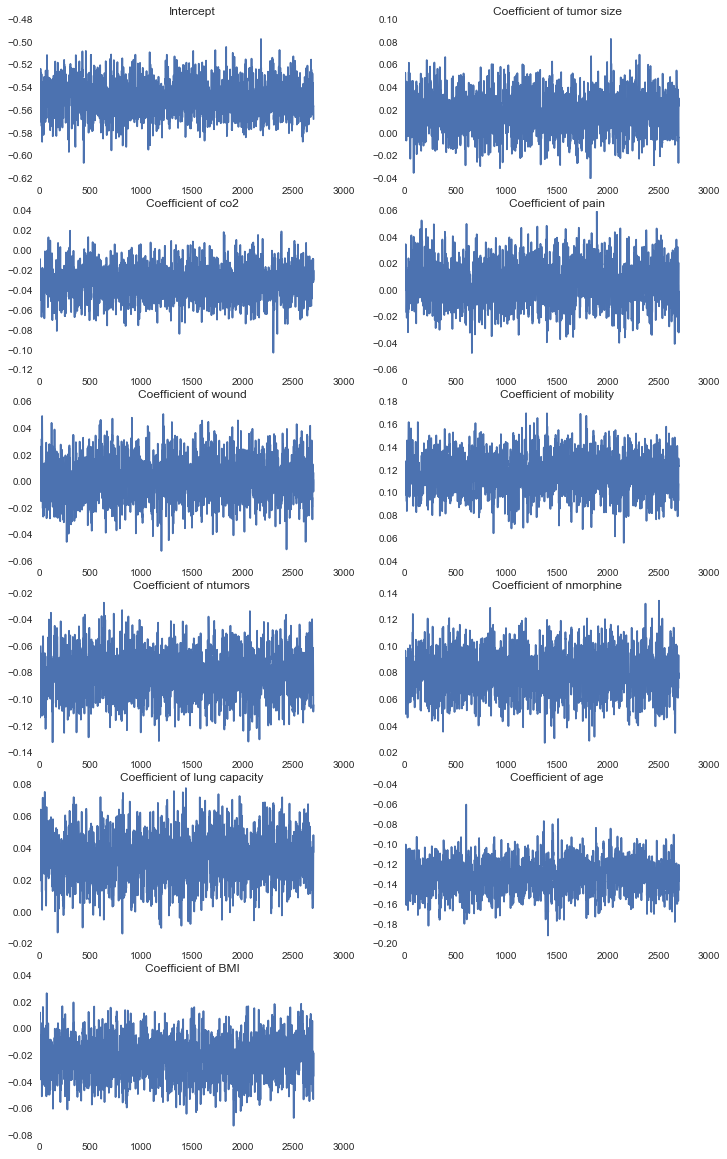

In [18]:
# Let us inspect the coefficients now
print coeffs.shape
print coeffs[coeffs.shape[0]-1,]
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
axarr[0,0].plot(range(0,coeffs.shape[0]),coeffs[:,0])
axarr[0,0].set_title('Intercept')
axarr[0,1].plot(range(0,coeffs.shape[0]),coeffs[:,1])
axarr[0,1].set_title('Coefficient of tumor size')
axarr[1,0].plot(range(0,coeffs.shape[0]),coeffs[:,2])
axarr[1,0].set_title('Coefficient of co2')
axarr[1,1].plot(range(0,coeffs.shape[0]),coeffs[:,3])
axarr[1,1].set_title('Coefficient of pain')
axarr[2,0].plot(range(0,coeffs.shape[0]),coeffs[:,4])
axarr[2,0].set_title('Coefficient of wound')
axarr[2,1].plot(range(0,coeffs.shape[0]),coeffs[:,5])
axarr[2,1].set_title('Coefficient of mobility')
axarr[3,0].plot(range(0,coeffs.shape[0]),coeffs[:,6])
axarr[3,0].set_title('Coefficient of ntumors')
axarr[3,1].plot(range(0,coeffs.shape[0]),coeffs[:,7])
axarr[3,1].set_title('Coefficient of nmorphine')
axarr[4,0].plot(range(0,coeffs.shape[0]),coeffs[:,8])
axarr[4,0].set_title('Coefficient of lung capacity')
axarr[4,1].plot(range(0,coeffs.shape[0]),coeffs[:,9])
axarr[4,1].set_title('Coefficient of age')
axarr[5,0].plot(range(0,coeffs.shape[0]),coeffs[:,10])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

#### Plot the Coefficient Density

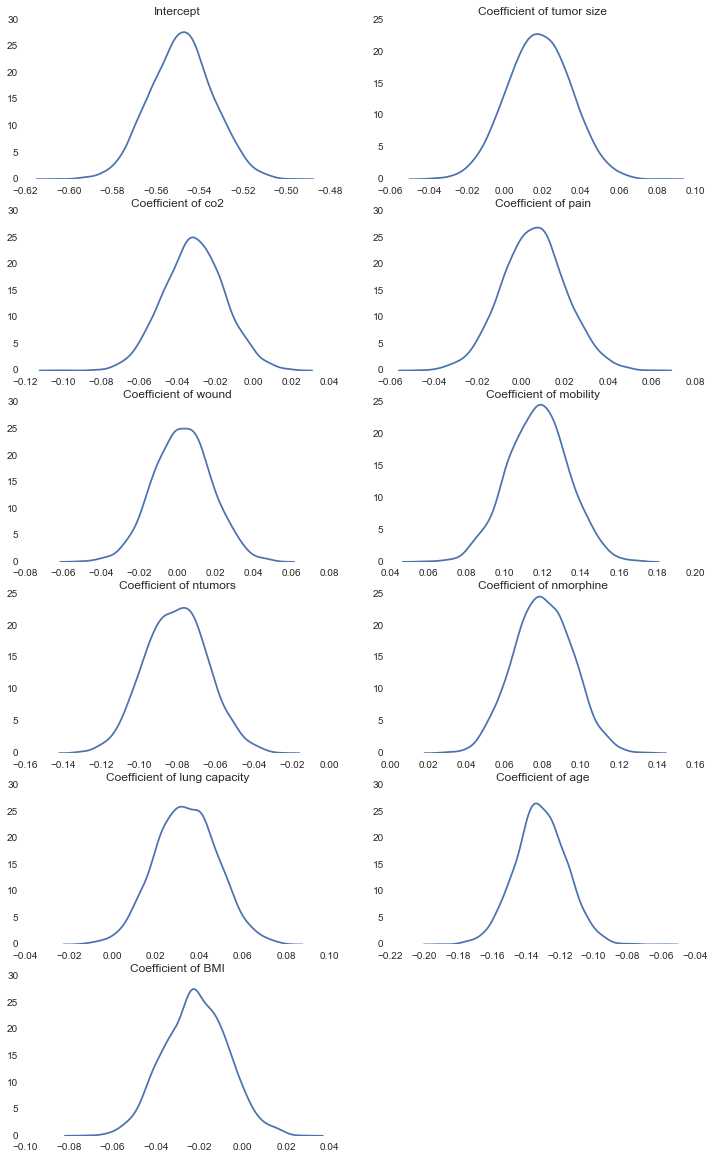

In [19]:
# Let us inspect the coefficients now
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
sns.kdeplot(coeffs[:,0], ax=axarr[0,0])
axarr[0,0].set_title('Intercept')
sns.kdeplot(coeffs[:,1],ax=axarr[0,1])
axarr[0,1].set_title('Coefficient of tumor size')
sns.kdeplot(coeffs[:,2], ax=axarr[1,0])
axarr[1,0].set_title('Coefficient of co2')
sns.kdeplot(coeffs[:,3],ax=axarr[1,1])
axarr[1,1].set_title('Coefficient of pain')
sns.kdeplot(coeffs[:,4],ax=axarr[2,0])
axarr[2,0].set_title('Coefficient of wound')
sns.kdeplot(coeffs[:,5],ax=axarr[2,1])
axarr[2,1].set_title('Coefficient of mobility')
sns.kdeplot(coeffs[:,6],ax=axarr[3,0])
axarr[3,0].set_title('Coefficient of ntumors')
sns.kdeplot(coeffs[:,7],ax=axarr[3,1])
axarr[3,1].set_title('Coefficient of nmorphine')
sns.kdeplot(coeffs[:,8],ax=axarr[4,0])
axarr[4,0].set_title('Coefficient of lung capacity')
sns.kdeplot(coeffs[:,9],ax=axarr[4,1])
axarr[4,1].set_title('Coefficient of age')
sns.kdeplot(coeffs[:,10],ax=axarr[5,0])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

#### Inspect the mean and median of the coefficients

In [20]:
# What are the mean and median coeffs
beta_mean = np.mean(coeffs,axis=0)
beta_median = np.median(coeffs,axis=0)
print beta_mean
print beta_median

[-0.54820908  0.01809141 -0.03137505  0.00585594  0.00263987  0.11742895
 -0.08063906  0.08013439  0.0339533  -0.13120521 -0.02163108]
[-0.5480161   0.01812078 -0.03147139  0.00576608  0.00271027  0.117701
 -0.08038793  0.07994441  0.03380994 -0.1315524  -0.021684  ]


#### Let us now validate our code with R MCMCPack's MCMCProbit function

In [23]:
%load_ext rmagic

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [24]:
%%R
library("MCMCpack")
R_df = read.csv(file="~/Projects/gitrepo/data-science-on-mpp/BayesianAnalysis/lung_cancer_remission.csv",head=TRUE,sep=",")
R_X = data.frame(
        R_df$tumorsize, 
        R_df$co2, 
        R_df$pain, 
        R_df$wound, 
        R_df$mobility, 
        R_df$ntumors, 
        R_df$nmorphine, 
        R_df$lungcapacity, 
        R_df$Age, 
        R_df$BMI
    )
R_X_std = scale(R_X)
R_data = data.frame(R_X_std,R_df$remission)
posterior = MCMCprobit(
                R_data$R_df.remission~
                    R_data$R_df.tumorsize+
                    R_data$R_df.co2+
                    R_data$R_df.pain+
                    R_data$R_df.wound+
                    R_data$R_df.mobility+
                    R_data$R_df.ntumors+
                    R_data$R_df.nmorphine+
                    R_data$R_df.lungcapacity+
                    R_data$R_df.Age+
                    R_data$R_df.BMI, 
                data = R_data, 
                burnin = 300, 
                mcmc = 3000,
                thin = 1, 
                verbose = FALSE, 
                seed = NA, 
                beta.start = NA,
                b0 = 0, 
                B0 = 1, 
                bayes.resid = FALSE
            ) 
summary(posterior)


Iterations = 301:3300
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 3000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                              Mean      SD  Naive SE Time-series SE
(Intercept)              -0.548917 0.01459 0.0002663      0.0004286
R_data$R_df.tumorsize     0.019838 0.01641 0.0002996      0.0004819
R_data$R_df.co2          -0.032091 0.01616 0.0002950      0.0004560
R_data$R_df.pain          0.005765 0.01543 0.0002817      0.0004283
R_data$R_df.wound         0.002422 0.01517 0.0002770      0.0004536
R_data$R_df.mobility      0.117664 0.01623 0.0002963      0.0004798
R_data$R_df.ntumors      -0.081387 0.01591 0.0002904      0.0004662
R_data$R_df.nmorphine     0.080207 0.01478 0.0002698      0.0004231
R_data$R_df.lungcapacity  0.035507 0.01502 0.0002743      0.0004257
R_data$R_df.Age          -0.131419 0.01474 0.0002691      0.0004315
R_data$R_df.BMI          -0.022133 0.01460 0.0002666    

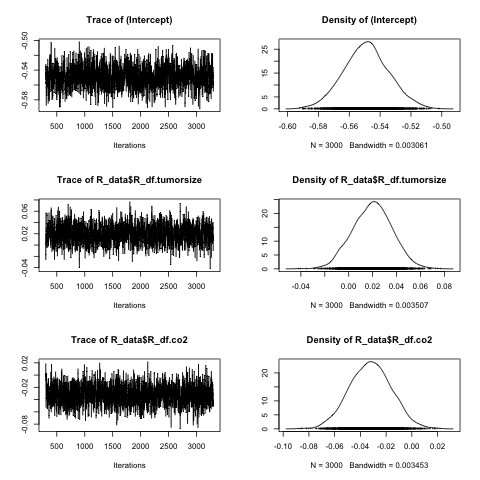

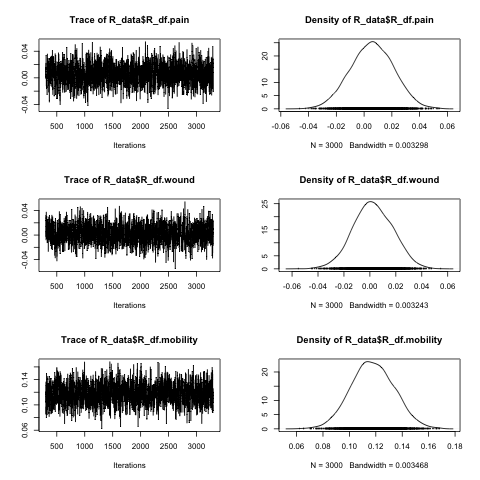

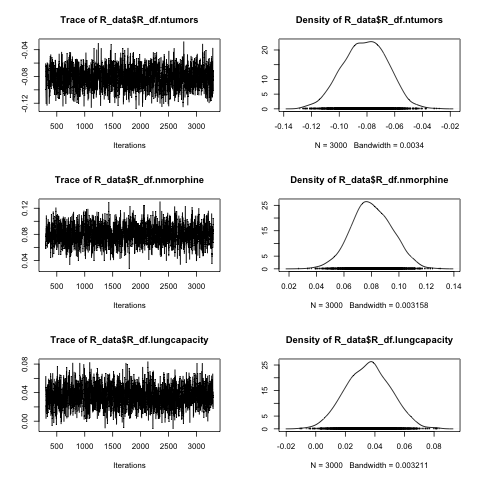

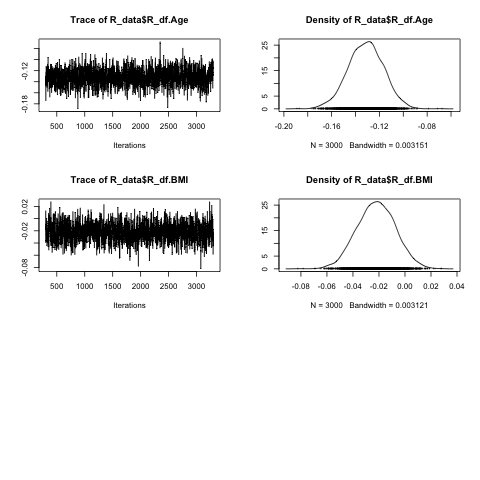

In [25]:
%R plot(posterior)